Pavan Dalwadi

psd498

Part 1

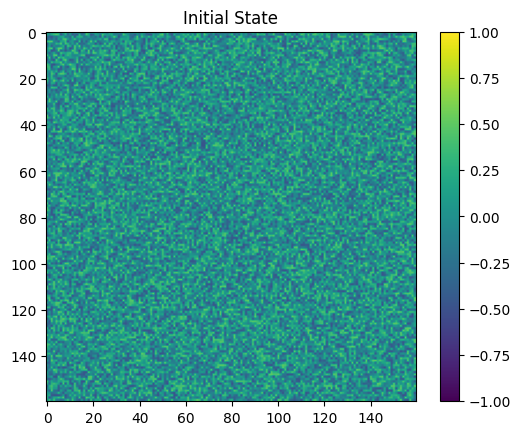

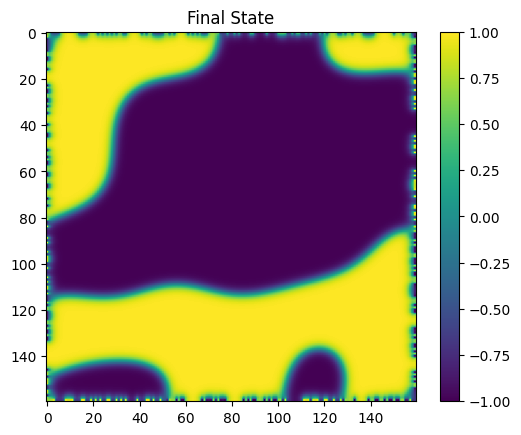

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

class AllenCahn:
    """
    Implementation of the Allen-Cahn equation in two dimensions using method of lines and explicit finite differences.

    Parameters:
        nx (int): Number of grid points in the x direction.
        ny (int): Number of grid points in the y direction.
        kappa (float): Reaction rate.
        d (float): Diffusion coefficient.
        Lx (float): Length of the domain in the x direction.
        Ly (float): Length of the domain in the y direction.
    """

    def __init__(self, nx, ny, kappa=1.0, d=1.0, Lx=1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.d = d
        self.kappa = kappa

    def _laplace(self, grid):
        """
        Computes the discrete Laplacian using finite differences with reflection boundary conditions.
        """
        lap = np.zeros_like(grid)
        
        # Compute the interior points using central finite differences
        lap[1:-1, 1:-1] = (
            (grid[:-2, 1:-1] + grid[2:, 1:-1] - 2 * grid[1:-1, 1:-1]) / self.dx**2 +
            (grid[1:-1, :-2] + grid[1:-1, 2:] - 2 * grid[1:-1, 1:-1]) / self.dy**2
        )
        
        # Reflection boundary conditions (Neumann)
        lap[:, 0] = lap[:, 1]   # Left boundary
        lap[:, -1] = lap[:, -2] # Right boundary
        lap[0, :] = lap[1, :]   # Top boundary
        lap[-1, :] = lap[-2, :] # Bottom boundary

        return lap

    def _reaction(self, y):
        """
        Computes the bistable reaction term.
        """
        return y * (1 - y**2)

    def rhs(self, t, y):
        """
        Computes the right-hand side of the Allen-Cahn equation.
        """
        y = y.reshape((self.ny, self.nx))
        diffusion_term = self.d * self._laplace(y)
        reaction_term = self.kappa * self._reaction(y)
        return (diffusion_term + reaction_term).flatten()

    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solves the Allen-Cahn equation using solve_ivp.

        Args:
            y0 (np.ndarray): Initial condition.
            t_min (float): Start time.
            t_max (float): End time.
            nt (int): Number of time points.
            **kwargs: Additional arguments for solve_ivp.

        Returns:
            tpts (np.ndarray): Time points of the solution.
            sol (np.ndarray): Solution of the PDE at each time point.
        """
        tpts = np.linspace(t_min, t_max, nt)
        out = solve_ivp(self.rhs, (t_min, t_max), y0.flatten(), t_eval=tpts, **kwargs)
        sol = out.y.T
        return tpts, sol.reshape((len(tpts), self.ny, self.nx))

# Testing the implementation
if __name__ == "__main__":
    np.random.seed(0)
    ic = np.random.random((160, 160)) - 0.5
    model = AllenCahn(160, 160, kappa=10, d=0.001)
    tpts, sol = model.solve(ic, 0, 8, 400, method="DOP853")

    # Check the initial and final states for visual validation
    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(sol[0], vmin=-1, vmax=1)
    plt.title("Initial State")
    plt.colorbar()

    plt.figure()
    plt.imshow(sol[-1], vmin=-1, vmax=1)
    plt.title("Final State")
    plt.colorbar()
    plt.show()


Q: Describe how varying  D  and  κ  change the properties of your solution. Is this consistent with your intuition for special cases in which this equation is solvable?
A: Increasing the diffusion coefficient D causes the concentration field to smooth out faster. This results in a more homogeneous final state, reducing the sharp boundaries between phases. Decreasing D slows down the smoothing effect, allowing the reaction term to dominate, leading to more distinct and well-defined domains or patterns.
Increasing the reaction rate κ amplifies the bistable reaction term, which promotes rapid separation into two distinct phases (ρ≈±1). Decreasing κκ reduces the influence of the reaction term, making the system behave more like the heat equation, where diffusion dominates, and the concentration tends toward a uniform state.

Q: Try changing the mesh size, integration timestep, or integration duration. Under what conditions does the solver fail? What do failures look like for this solution method?
A: A smaller mesh size (higher resolution) increases the accuracy but also increases the computational cost and memory usage. 
If the timestep is too large, the solver might skip over important changes in the solution, leading to inaccurate results.
For longer durations, the system typically settles into a steady state.
Failures manifest as divergence: where the values of the solution grow uncontrollably large and oscillations: where the solution shows non-physical oscillations, especially near boundaries or sharp gradients.

Q: Based on what you know about analytical results for the heat equation, can you guess why this might be the case? What kind of photo-editing operation does the reaction term in our system mimic?
A: The Gaussian blur resembles the effect of the diffusion term because both processes smooth out high-frequency details. The diffusion equation acts as a low-pass filter, spreading out concentrations and eliminating sharp transitions, similar to how a Gaussian blur reduces image sharpness by averaging pixel values. The reaction term mimics a thresholding operation or a contrast enhancement in photo editing.


Part 2

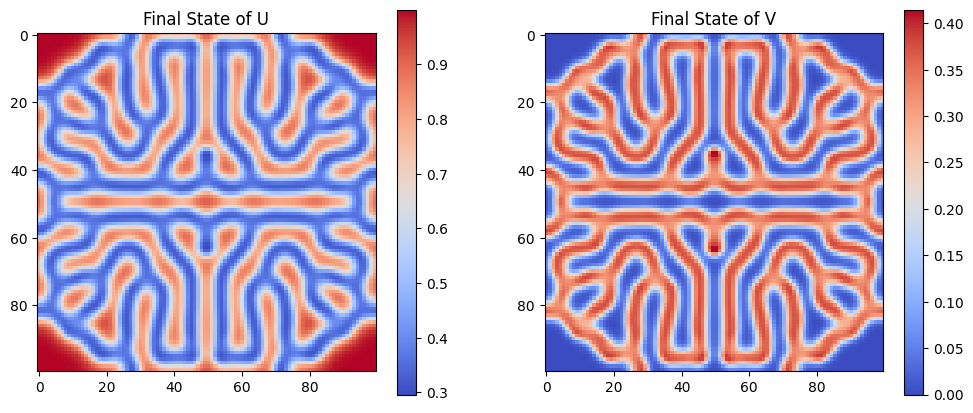

In [2]:
#!/usr/bin/python
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def make_initial_conditions(n):
    """
    Make a bump-shaped initial conditions array
    """
    xx, yy = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
    rr = (xx**2 + yy**2)**0.5
    u_ic = 1 - 0.5 * np.copy(np.exp(-rr**2 - xx**2))
    v_ic = 0.25 * np.copy(np.exp(-rr**2))
    return u_ic, v_ic

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model
    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        # Define the mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)
        self.ksq = kxx**2 + kyy**2

    def _reaction(self, y):
        """
        Compute the reaction term in real space
        """
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        uv2 = u * (v**2)
        rxn_u = -uv2 + self.b * (1 - u)
        rxn_v = uv2 - self.kappa * v
        y_out = np.hstack([rxn_u, rxn_v])
        return y_out

    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        y = np.reshape(y, (self.nx, self.ny))
        yk = np.fft.fft2(y)
        lap = -self.ksq * yk
        lap = np.fft.ifft2(lap)
        return np.real(lap).flatten()

    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space
        """
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]
        lap_u = self._laplace(u)
        lap_v = self._laplace(v)
        u_out = self.du * lap_u
        v_out = self.dv * lap_v
        y_out = np.hstack([u_out, v_out])
        return y_out

    def rhs(self, t, y):
        """
        Combine reaction and diffusion terms
        """
        return self._reaction(y) + self._diffusion(y)

    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the system using solve_ivp
        """
        u0, v0 = y0
        tpts = np.linspace(t_min, t_max, nt)
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=tpts, **kwargs)
        sol = out.y.T
        
        u = sol[:, :self.nx * self.ny].reshape((nt, self.ny, self.nx))
        v = sol[:, self.nx * self.ny:].reshape((nt, self.ny, self.nx))
        return tpts, np.stack([u, v], axis=-1)

# Testing the implementation
if __name__ == "__main__":
    nx, ny = 100, 100
    du, dv = 0.1, 0.05
    b, kappa = 0.0545, 0.1165
    Lx, Ly = 1.0, 1.0

    # Create initial conditions
    u_ic, v_ic = make_initial_conditions(nx)

    # Create model instance and solve
    model = GrayScott(nx, ny, du, dv, b, kappa, Lx, Ly)
    tpts, sol = model.solve((u_ic, v_ic), 0, 5000, 500, method="DOP853")

    # Plot the final state of u and v
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sol[-1, ..., 0], cmap="coolwarm")
    plt.title("Final State of U")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(sol[-1, ..., 1], cmap="coolwarm")
    plt.title("Final State of V")
    plt.colorbar()

    plt.show()


Q: We mentioned that performing Fourier transforms at each timestep is more expensive per mesh point than computing the discrete Laplacian at each timestep. Can you give a more mathematical reason for this advantage, based on runtime scaling of Fourier transforms? How many fewer mesh points would we need to compensate?
A: The computational complexity of the Fast Fourier Transform (FFT) is O(Nlog⁡N), where N is the total number of mesh points (N=nx*ny​). In contrast, computing the discrete Laplacian using finite differences has a computational complexity of O(N), as it only involves a few arithmetic operations per mesh point. 

Q:Try playing around with the number of timepoints and the number of space points. When does the spectral method fail? How do these failures differ from the ones we saw with the real-space finite difference scheme we used for the Allen-Cahn equations?
A: The spectral method tends to fail when the grid resolution (number of space points) is too low, leading to aliasing errors or when the timestep is too large, causing numerical instability. 
They differ from the Allen-Cahen model because the finite-difference scheme can suffer from numerical diffusion, where sharp features are artificially smoothed out over time

Q:We assumed periodic boundary conditions, which makes this problem easier to implement. How do you expect our results would change, if we had Dirichlet boundary conditions?
A: The edges would act as sinks for the chemical species, damping out the patterns near the boundaries and the overall symmetry of the Turing patterns would be broken because the boundary conditions would disrupt the periodic nature of the domain.
